In [156]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # 'last' 'none' ...

import pymrio
import pandas as pd
import numpy as np
# import scipy as sp
import scipy.sparse as sp
import matplotlib.pyplot as plt
import operator
import pickle

In [2]:
path_io = '/mnt/dd/adrien/Économie/Données/'
# path_io = '/media/sf_U_DRIVE/Données/'
path_exio = path_io + 'Exiobase 2.2/'

In [4]:
embodied_hours, embodied_gain, embodied_labor, embodied_va = pickle.load(open("labor_exio.pkl", 'rb')) # no need for next block

In [ ]:
exio2p = pymrio.parse_exiobase2(path=path_exio+'mrIOT_PxP_ita_coefficient_version2.2.2.zip', charact=True, popvector='exio2')
exio2p.calc_all()
exio2p.y = np.sum(exio2p.Y, axis=1)
# exio2i = pymrio.parse_exiobase2(path=path_exio+'mrIOT_IxI_fpa_coefficient_version2.2.2.zip', charact=True, popvector='exio2')

In [5]:
WB_data = pd.DataFrame(pd.ExcelFile(path_exio+'/WB_data.xls').parse(0)[0:47])
WB_data.set_index('region', inplace=True)
# Euro conversion (WB_data is in dollars but Exiobase is in euros)
USD_EUR = 0.730754
EUR_USD = 1.370478
Wh_J = 3600
WB_data[['GDP_PPP','GDP','GDPpc','GDPpcPPP','Export','Import','Value_added']] = pow(10,-6)*USD_EUR*WB_data[['GDP_PPP','GDP','GDPpc','GDPpcPPP','Export','Import','Value_added']]
# To retrieve the data: go to the following URL and select only year 2007: 
# 'http://databank.worldbank.org/data/reports.aspx?source=2&series=' + \
# ','.join(pd.DataFrame(pd.ExcelFile(path_exio+'/WB_data.xls').parse(1)[1:(len(WB_data.iloc[0])-2)])['Code']) + '&country=' + \
# ','.join(WB_data.loc[regions]['Code'][list(range(39))+list(range(40,43))])+',MEA,SAS,EAS,LCN,NAC,ECS,SSF,WLD'
# Usage: 
# WB_data.loc[['FR']][['Import','Export']]

In [131]:
# embodied_import(regs_imp=regions, secs=sectors, var='Employment', add=True, join=False)
# div0(embodied_conso('FR')[index_regs_secs('FR', sectors)],
# np.array(exio2p.x.iloc[index_regs_secs('FR',sectors)]).flatten())
# embodied_conso('FR')[index_regs_secs('FR', sectors)]
# np.array(exio2p.x.iloc[index_regs_secs('FR',sectors)]).flatten()
# exio2p.x.loc[['FR',sectors],:]
# exio2p.x.loc[[('FR',sectors)]]
# exio2p.x.loc[['FR',('Paddy rice', 'Wheat')],:]
# exio2p.x.loc[['FR',('Paddy rice', 'Wheat')]]
# embodied_conso('FR')[index_regs_secs('FR', sectors)]
# sectors
# exio2p.x.loc['FR', list(sectors)]

In [261]:
reg = reg_ref = 'FR'
regs = regs_ref = ['FR', 'AT']
sec= 'Wheat'
secs = ['Pigs', 'Wheat']
# del reg reg_ref regs sec secs

sectors = np.array(exio2p.get_sectors()) # list(exio2p.get_sectors())
regions = list(exio2p.get_regions())
nb_sectors = len(sectors)
nb_regions = len(regions)
impact_vars = np.array(exio2p.impact.unit.iloc[:,0].index)

# The only domains whose value can be negative in Y are 'Changes in inventories' and 'Changes in valuables'
#   stable_domain are the other ones, and are less prone to 2007-specific values
stable_domain = ['Final consumption expenditure by government', 'Gross fixed capital formation', 'Export', \
    'Final consumption expenditure by non-profit organisations serving households (NPISH)', \
    'Final consumption expenditure by households']
def name_var(var):
    if var=='hours' or var=='hour' or var=='Employment hour': return('Employment hour')
    elif var=='employment' or var=='empl' or var=='labor' or var=='Employment': return('Employment')
    elif var=='energy' or var=='Total Energy Use' or var=='use': return('Total Energy Use')
    elif var=='Total Energy supply' or var=='energy supply' or var=='supply': return('Total Energy supply')
    elif var=='Total Energy inputs from nature': return('Total Energy inputs from nature')
    elif var=='Total Emission relevant energy use': return('Total Emission relevant energy use')
    else: return('unknown')
    
# def div0(a, b): return(np.divide(a, b, out=np.zeros_like(a), where=b!=0))
def div0(a, b, replace_by=0):
    '''
    Returns the Hadamard division of the arrays (or matrices) of same shape a and b, where elements of the results are 0 in locations where those of b are 0.
    '''
    if sp.issparse(b): 
        b = np.array(b.toarray(), dtype='float')
        sparse = True
    else: sparse = False
    if type(a)==int or type(a)==float: a = a*np.ones_like(b)
    if sp.issparse(a): a = a.toarray()
    a = np.array(a, dtype='float')
#     b = np.array(b, dtype='float')
    div = np.divide(a, b, out=np.array(replace_by*np.ones_like(a)), where=b!=0)
    if sparse: return(sp.csc_matrix(div)) # TODO: a true sparse division, not through dense matrix
    else: return(div)
def sorted_series(series): return(sorted(series.items(), reverse=True, key=operator.itemgetter(1)))

# /!\ Python sorts regs and secs before applying the function
def index_regs(regs): return(np.where(list(map(lambda r: r in regs, regions)))[0]) # for list of str
def index_secs(secs): return(np.where(list(map(lambda s: s in secs, sectors)))[0]) # indexes of a list of sectors
def index_regs_secs(regs=regions, secs=sectors):  # all combinations of indexes
    return(np.repeat(index_regs(regs)*nb_sectors, len(secs)*(type(secs)!=str)+(type(secs)==str)) \
           + np.tile(index_secs(secs), len(regs)*(type(regs)!=str)+(type(regs)==str)) )

def inter_secs(secs1, secs2): 
    '''
    Returns the intersection of lists secs1 and secs2.
    '''
    return(list(np.array(secs1)[np.where([sec in secs2 for sec in secs1])[0]]))

def not_regs(regs): return(list(filter(lambda r: r not in regs, regions)))
# def not_secs(secs): return(list(filter(lambda r: r not in secs, sectors)))
def regs_or_no(regs, yes=True):
    if yes: res = regs
    else: res = not_regs(regs)
    if type(res)==str: res=[res]
    return(res)
# def regs_secs_index(indexes): return([(regions[index//nb_sectors], sectors[index % nb_sectors]) for index in indexes])


def final_demand(secs=sectors, regs=regions): 
    indexes = index_regs_secs(regs, sectors)
    return(exio2p.Y[[(reg,dom) for reg in regions for dom in stable_domain]].sum(axis='columns')*list(map(lambda i: i in indexes, range(nb_regions*nb_sectors))))
# Embodied conso is a notion of transaction, not of value added (it includes intermediary goods)!
def embodied_conso(regs=regs_ref, secs=sectors): return(np.dot(exio2p.L, final_demand(secs, regs)))

def impact(var, regs=regions, secs=sectors, join_sort=False):
    if type(regs)==str: regs=[regs]
    if var=='unknown': var='Value Added'
    if join_sort: return(sorted_series(exio2p.impact.F.loc[var].loc[regs,secs].groupby('sector').sum()))
    else: return(exio2p.impact.F.loc[var].loc[regs,secs])

def value_added(regs = regions, secs = sectors, add=True, positive=False): # /!\ Can be negative ! ex: 'AT', 'Cattle'
    if type(regs)==str: regs = [regs]
    if type(secs)==str: secs = [secs]
    if positive: indexes = [0]+list(range(2,8)) # remove 'Other net taxes on production' and 'Operating surplus: remaining'
    else: indexes = list(range(0,9))
    if add: return(exio2p.factor_inputs.F.iloc[indexes].sum().loc[regs,secs].groupby('region').sum())
    else: return(exio2p.factor_inputs.F.iloc[indexes].sum().loc[regs,secs])

def gdp(regs = regions): return(value_added(regs))    

def export(regs, method='direct', join=False):
    if type(regs)==str: regs=[regs]
    if join: # exports of the area regs outside this area. 
        # /!\ This method uses the transactional notion of embodied conso: overestimates exports
        if method=='embodied':
            return(embodied_conso(not_regs(regs))[index_regs_secs(regs)].sum())
        elif method=='direct':
            return(np.array(exio2p.Z.loc[[(reg,sec) for sec in sectors for reg in regs]][not_regs(regs)].sum().sum()) \
                  + np.array(exio2p.Y.loc[[(reg,sec) for sec in sectors for reg in regs]][not_regs(regs)].sum().sum()))
    else: # list of exports of each reg in regs
        if method=='embodied': # /!\ cf. above
            return([embodied_conso(not_regs(reg))[index_regs_secs(reg)].sum() for reg in regs])
        elif method=='direct':
            return(np.array([exio2p.Z.loc[[(reg,sec) for sec in sectors]][not_regs(reg)].sum().sum() for reg in regs]) \
                  + np.array([exio2p.Y.loc[[(reg,sec) for sec in sectors]][not_regs(reg)].sum().sum() for reg in regs]))

    
def Import(regs, method='direct', join=False): 
    if type(regs)==str: regs=[regs]
    if join: return(export(not_regs(regs), method)) # exports of the area regs outside this area. 
    else: # list of exports of each reg in regs
        if method=='embodied': # /!\ cf. above
            return([embodied_conso(reg)[index_regs_secs(not_regs(reg))].sum() for reg in regs])
        elif method=='direct':
            return(np.array([exio2p.Z.loc[[(r,sec) for sec in sectors for r in not_regs(reg)]][reg].sum().sum() \
              for reg in regs]) + np.array([exio2p.Y.loc[[(r,sec) for sec in sectors for r in not_regs(reg)]][reg].sum().sum() for reg in regs]))

#  /!\ Some data on Employment hour is aberrant, hence it can be computed indirectly assuming that a year = 1600 hours
def hourly_wage(regs, secs = sectors, indirect=False, positive=False): 
    va = pow(10,6)*np.array(value_added(regs, secs, add=False, positive=positive))
    if indirect: hours = pow(10,3)*np.array(impact('Employment', regs, secs))*1600
    else: hours = np.array(impact('Employment hour', regs, secs))
    return(div0(va, hours))
    
def embodied_import(regs_imp=regs_ref, regs_exp=None, secs=sectors, var='empl', add=True, join=False, round_bn=False):
    '''
    sums across all regions embodied hours/employment/gain (=var) imported from sectors secs in regs_exp to regs_exp,
    where var embodied in imports from reg to regs_imp in sector secs is equal to the product of:
    . share of production in sec in reg exported to regs_imp
    . (hours of, if var='hours') employment in sec in reg
    . (if var=='gain') hourly wage in regs_imp - hourly wage in reg
    add=True sums all hours/gain/employment across sectors
    '''
    # taking share_export if function of embodied_conso instead of embodied_value_added amounts to assume that the 
    #    ratio of value_added per production is constant within a sector-region among the different processes
    #    Indeed, if say all Korean imports of embodied Chinese labor and only them consist in small transformation
    #    of an higly valued imported product (say from Vietnam), then our calculations of Korean imports of Chinese labor 
    #    will be biased upward, and imports of Chinese labor by other countries biased downard. 
    #    Still, this assumption seems reasonable. And we cannot relax it simply (if so, we could not use L any more,
    #    we would have to compute A, A^2, A^3,... and the value added at each step in the global value chain).
    Var = name_var(var)    
    if join:
        if regs_imp is None: print('regs_imp should not be None for join=True')
        if type(regs_exp)==str: nb_regs_exp = 1
        else: nb_regs_exp = len(regs_exp)
        if regs_exp is None: regs_exp = not_regs(regs_imp) 
#         share_export = div0(embodied_conso(regs_imp)[index_regs_secs(regs_exp, secs)], exio2p.x.loc[regs_exp,secs]) # was that, doesn't work in 2020
        share_export = div0(embodied_conso(regs_imp)[index_regs_secs(regs_exp, secs)], np.array(exio2p.x.iloc[index_regs_secs(regs_exp, secs)]).flatten())
        if Var!='gain': res = impact(Var, regs_exp, secs)*share_export
        else: # gain = gain en $ que l'importateur regs_imp a à importer plutôt qu'à produire chez lui (dû à la différence de salaire horaire)
            hourly_wage_ref = np.tile(hourly_wage(regs_imp, secs), nb_regs_exp)
            res = (hourly_wage_ref - hourly_wage(regs_exp, secs))*impact('Employment hour', regs_exp, secs)*share_export
    else:
        if regs_exp is None: 
            regs_ref = regs_imp
            yes = True
        elif regs_imp is None:
            regs_ref = regs_exp
            yes = False
        else: print("regs_exp or regs_imp should be None for join=False")
#         share_export = np.array([div0(embodied_conso(regs_or_no(reg, yes))[index_regs_secs(regs_or_no(reg, not yes), \
#                                 secs)], exio2p.x.loc[regs_or_no(reg, not yes),secs]) for reg in regs_ref]) # was that, doesn't work anymore in 2020
        share_export = np.array([div0(embodied_conso(regs_or_no(reg, yes))[index_regs_secs(regs_or_no(reg, not yes), \
                                secs)], np.array(exio2p.x.iloc[index_regs_secs(regs_or_no(reg, not yes),secs)]).flatten()) for reg in regs_ref])
        if  Var!='unknown': 
            res = np.array([impact(Var, regs_or_no(reg, not yes), secs) for reg in regs_ref])*share_export
        else:          
            hourly_wage_ref = np.array([np.tile(hourly_wage(reg, secs), len(regions)-1) for reg in regs_ref])
            hourly_wage_not_ref = np.array([hourly_wage(regs_or_no(reg, not yes), secs) for reg in regs_ref])
            hours = np.array([impact('Employment hour', regs_or_no(reg, not yes), secs) for reg in regs_ref])
#              # /!\ Employment hours are computed indirectly because data is aberrant
#             hours = 1600*np.array([impact('Employment', regs_or_no(reg, not yes), secs) for reg in regs_ref])
            if regs_imp is None:
                share_export = np.array([np.concatenate([div0(embodied_conso(r)[index_regs_secs([reg], secs)], \
#                     exio2p.x.loc[[reg],secs]) for r in not_regs(reg)]) for reg in regs_ref]) # was that, doesn't work anymore in 2020
                      np.array(exio2p.x.iloc[index_regs_secs(reg,secs)]).flatten()) for r in not_regs(reg)]) for reg in regs_ref])
                hours = np.array(list(map(lambda r: np.tile(r,(len(regions)-1)), hours))) 
                hourly_wage_not_ref = np.array([np.concatenate([hourly_wage(r, secs, indirect=True, \
                    positive=True) for r in not_regs(reg)]) for reg in regs_ref]) # TODO: better assessment of hourly wages
            res = (hourly_wage_ref - hourly_wage_not_ref)*hours*share_export
    if not add:
        if round_bn:
            return(round(res*pow(10,-9)))
        else:
            return(res)
    else:
        if join: 
            r = res.sum()
            if Var=='Employment hour': res = print(round(r), 'hours')
            elif Var=='Employment': print(round(r*pow(10,-3),1), 'M persons')
            else: print(round(r*pow(10,-9),1), 'G€')
        else: r = [res[i].sum() for i in range(len(res))]
        if round_bn:
            return(round(r*pow(10,-9)))
        else:
            return(r)
        
def embodied_export(regs_exp=regs_ref, regs_imp=None, secs=sectors, var='empl', add=True, join=False, round_bn=False):
    return(embodied_import(regs_imp, regs_exp, secs=secs, var=var, add=add, join=join, round_bn=round_bn))
    
def commanded_import_to_export(regs = regions, var='Employment', secs=sectors, join=False, detail=True):
    if type(regs)==str: regs=[regs] # Employment used instead of employment hours because data is sometimes aberrant for the latter
    imp = np.array(embodied_import(regs_imp=regs, secs=secs, var=var, add=True, join=join))
    exp = np.array(embodied_export(regs_exp=regs, secs=secs, var=var, add=True, join=join))
    var_regs = [impact(name_var(var), reg, secs=secs).sum() for reg in regs]
    if var=='gain': var_regs=pow(10,6)*np.array(var_regs)
    df = pd.DataFrame({'imp/exp': imp/exp, 'import': imp, 'export': exp, var: var_regs, 'share_export': exp/var_regs, \
                   'share_net_export': (exp-imp)/var_regs, 'share_import': imp/var_regs}, index=regs)
    if detail: return(df)
    else: return(ratio)
    
# def gain_loss_reg_import(reg_ref=reg_ref):
#     gains = embodied_import(reg_ref, var='gain', add=False)
#     gain = gains[np.where(gains>0)[0]].sum()
#     loss = -gains[np.where(gains<0)[0]].sum()
#     print('gain:',round(gain*pow(10,-9),1), 'G€')
#     print('loss:',round(loss*pow(10,-9),1), 'G€')
#     return([gain, loss])
    
# TODO: %GDP per country ; in hours pc ; in PPP ; regressions ; I/E par / salaire moyen mondial (par secteur ou non) ; 
# variation du PIB si les salaires étaient égaux: calcul de imports * (1 - imports/gain) (/ PIB)
#    -> interprétation: ce qu'on pourrait encore importer à salaires égaux, ramenés aux prix d'importations actuels
# - separate the 'productivity' bonus (cf. Ibarrola, Nishioka) from the 'domination' surplus 
#  in differences in income (i.e. home related vs. trade related explanations)
# - not only EU
# - other stats, more telling: % net embodied labor relative to labor force ; 
#     ratio labor embodied in export / import ; main trade partners in terms of labor
# - not up-to-date (could use exiobase 2)
# - look at variability within countries: e.g., how many embodied labor does a French minimum wage consume? 
#  (Can be done either from national surveys on consumption, 
#  or more crudely, by allocating to minimum wage earners their share of consumption per capita)
    
# With Eora (Alsamawi etal, Reyes et al): - make a choropleth map
# - 'employment footprint' is the net labor embodied in import => do also the ratio  import/export of labor

In [ ]:
exio2p.Y

In [132]:
embodied_exports = export(regions, method='embodied')
embodied_imports = Import(regions, method='embodied')
exports = export(regions)
imports = Import(regions)
values_added = value_added(regions)
embodied_labor = commanded_import_to_export() # 660 M pers work for export over 3080 M, i.e. 21% / 27% African work for out
embodied_energies = commanded_import_to_export(var='energy') # TJ /!\ 50% of French energy exported ?! TODO: check
embodied_energy_supply = commanded_import_to_export(var='Total Energy supply') # TJ
# embodied_energy_nature = commanded_import_to_export(var='Total Energy inputs from nature') # exactly equal to energy_supply
# embodied_energy_emissive = commanded_import_to_export(var='Total Emission relevant energy use') # exactly equal to energy_supply
embodied_gain = commanded_import_to_export(var='gain') # gain=PIB, import=gain à l'importation, export=gain à l'export

In [144]:
embodied_hours = commanded_import_to_export(var = 'Employment hour')
embodied_va = commanded_import_to_export(var='Value Added')

In [267]:
pickle.dump([embodied_hours, embodied_gain, embodied_labor, embodied_va], open("labor_exio.pkl", "wb" ))

In [283]:
hours_per_va_in_import = embodied_va['import']*1e6/embodied_hours['import']
hours_per_va_in_export = embodied_va['export']*1e6/(1.6e6*embodied_labor['export']) # some data in hours is aberrant so we convert employment into hours using 1600h
price_imported_labor_wrt_national = hours_per_va_in_import/hours_per_va_in_export
average_hours_per_va = sum(embodied_va['export']*1e6)/sum(1.6e6*embodied_labor['export']) # $7/h

In [303]:
embodied_labor
# indexes = index_regs_secs('FR', sectors)
# list(map(lambda i: i in indexes, range(nb_regions*nb_sectors)))

,imp/exp,import,export,Employment,share_export,share_net_export,share_import,country_code,hours_per_va_in_export
AT,2.863525,2289.485815,799.534095,4163.215381,0.192047,-0.357885,0.549932,AT,41.707417
BE,6.132242,6267.521553,1022.060397,4380.907204,0.233299,-1.197346,1.430645,BE,49.126217
BG,0.940645,455.079941,483.795857,3269.278923,0.147982,0.008784,0.139199,BG,6.003936
CY,2.538519,150.197314,59.167298,373.571455,0.158383,-0.243675,0.402058,CY,21.455939
CZ,1.960695,2242.625352,1143.790744,5227.316160,0.218810,-0.210210,0.429020,CZ,14.868661
DE,4.018326,24807.161948,6173.506423,39742.926844,0.155336,-0.468855,0.624191,DE,40.794470
DK,5.034687,2221.035653,441.146756,2862.056711,0.154136,-0.621892,0.776028,DK,52.856639
EE,1.943741,254.513050,130.939782,655.992690,0.199606,-0.188376,0.387982,EE,15.538950
ES,7.075590,13941.706228,1970.394918,20634.514600,0.095490,-0.580160,0.675650,ES,31.955719
FI,4.205358,1656.011099,393.786033,2487.184244,0.158326,-0.507492,0.665818,FI,50.280784


In [321]:
# blah = final_demand(secs=sectors, regs='FR') #embodied_conso('FR')
# exio2p.Y[[(reg,dom) for reg in regions for dom in stable_domain]]\
#         .sum(axis='columns')*list(map(lambda i: i in index_regs_secs(regs, secs), range(nb_regions*nb_sectors)))

AT     0.371590
BE     0.289007
BG     2.214522
CY     0.638581
CZ     0.803794
DE     0.247898
DK     0.225612
EE     0.793328
ES     0.329975
FI     0.249743
FR     0.290601
GR     0.268639
HU     0.937077
IE     0.228452
IT     0.309833
LT     1.044661
LU     0.288972
LV     1.195361
MT     0.595398
NL     0.251693
PL     1.014826
PT     0.600504
RO     1.655438
SE     0.274646
SI     0.713223
SK     0.760702
GB     0.285864
US     0.202618
JP     0.305516
CN     8.844148
CA     0.256543
KR     0.454288
BR     2.082823
IN    10.846480
MX     0.672828
RU     0.580162
AU     0.126400
CH     0.302446
TR     0.591053
TW     1.336326
NO     0.098032
ID     3.419162
ZA     0.721859
WA     4.196117
WL     2.659502
WE     4.452336
WF    13.726268
WM     0.737758
dtype: float64

In [152]:
# gains = embodied_import(var='gain', add=False)
# gain = embodied_import(var='gain')
# sorted(gains.groupby('sector').sum().items(), reverse=True, key=operator.itemgetter(1)) # FR Gains by sector in G€
# sorted(gains.groupby('region').sum().items(), reverse=True, key=operator.itemgetter(1))[1:5] # FR Gains by region in G€

In [13]:
# # /!\ TODO: why is there a discrepancy with WB_data?
# (274+786)/2 # 530. Export from WB: 540!
# value_added('FR') # 1.773 T€
# WB_data['GDP']['FR'] # 1.946 T€
# WB_data['Value_added']['FR'] # 1.747 T€
# # Between 79% and 101% except 3 outliers (16%: RoW Eur, 43%: RoW America, 75%: RoW Asia):
# # sorted(values_added/WB_data['Value_added'][regions]) # 90-110% except 3 outliers
# # sorted(WB_data['GDP'][regions]/WB_data['Value_added'][regions])
# # sorted(embodied_exports/WB_data['Export'][regions]) # From 30% to 235%, with most of regs > 120%
# # sorted(exports/WB_data['Export'][regions]) # From 13% to 109% with most of regs > 70%
# # sorted(imports/WB_data['Import'][regions]) # From 60% to 100% except 5 outliers
# # sorted(embodied_imports/WB_data['Import'][regions])
# # sorted((exports/imports)/(WB_data['Export'][regions]/WB_data['Import'][regions])) # ~ 90-105% except 5 outliers

530.0

region
FR    1.773543e+06
dtype: float64

1946080.1193265808

1747189.204809745

In [ ]:
embodied_primary_energy = commanded_import_to_export(var='energy', secs=primary_energy_sectors)
embodied_secondary_energy = commanded_import_to_export(var='energy', secs=secondary_energy_sectors)
embodied_primary_energy_supply = commanded_import_to_export(var='Total Energy supply', secs=primary_energy_sectors)
embodied_secondary_energy_supply = commanded_import_to_export(var='Total Energy supply', secs=secondary_energy_sectors)
# FR: supply ~ use for prod and export (supply>use for import). primary < secondary (above all for prod)
embodied_primary_energy_supply.loc[['FR']]
embodied_secondary_energy_supply.loc[['FR']]

In [154]:
## choropleth map
# %load_ext signature
%matplotlib inline
import os
# import plotly.plotly as py
import chart_studio.plotly as py
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import geopandas as gpd
# import pySAL
# from helpers import slug

# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [245]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
world = pd.DataFrame(world[['iso_a3', 'continent']])
world.iso_a3[21] = 'FRA'
world.iso_a3[43] = 'NOR'
world.iso_a3[166] = 'SDS'
world.iso_a3[173] = 'MTN'

gdf = gpd.read_file('countries.shp')[['ADM0_A3', 'NAME', 'POP_EST', 'GDP_MD_EST', 'POP_YEAR', 'GDP_YEAR', 'ISO_A2', 'geometry']].to_crs('+proj=robin')
gdf = gdf[(gdf.POP_EST>0) & (gdf.NAME!="Antarctica")]
gdf['GDPpc'] = gdf.GDP_MD_EST/gdf.POP_EST
gdf = gdf.merge(world, left_on='ADM0_A3', right_on='iso_a3')
# def inter_secs(secs1, secs2): return(list(np.array(secs1)[np.where([sec in secs2 for sec in secs1])[0]]))
gdf['country_code'] = gdf.ISO_A2
gdf['country_code'].iloc[np.where(list(map(lambda r: r not in regions, gdf.ISO_A2)))[0]] = 'WM'
gdf['country_code'].iloc[inter_secs(np.where(gdf.continent=='Africa')[0], np.where(list(map(lambda r: r not in regions, gdf.ISO_A2)))[0])] = 'WF'
gdf['country_code'].iloc[inter_secs(np.where(gdf.continent=='Asia')[0], np.where(list(map(lambda r: r not in regions, gdf.ISO_A2)))[0])] = 'WA'
gdf['country_code'].iloc[inter_secs(list(np.where(gdf.continent=='South America')[0]) + list(np.where(gdf.continent=='North America')[0]), \
                               np.where(list(map(lambda r: r not in regions, gdf.ISO_A2)))[0])] = 'WL'
gdf['country_code'].iloc[inter_secs(np.where(gdf.continent=='Europe')[0], np.where(list(map(lambda r: r not in regions, gdf.ISO_A2)))[0])] = 'WE'
gdf['country_code'].iloc[np.where(gdf.NAME=='Norway')[0]] = 'NO'
gdf['country_code'].iloc[np.where(gdf.NAME=='France')[0]] = 'FR'
# np.array(regions)[list(np.where([reg not in list(gdf.country_code) for reg in regions])[0])]
embodied_labor['country_code'] = list(embodied_labor.index)
embodied_labor['hours_per_va_in_export'] = hours_per_va_in_export
merged = gdf.merge(embodied_labor, left_on='country_code', right_on='country_code', how='outer')
GDPpcMean = WB_data.GDP.sum()/WB_data.Population.sum()
merged['elasticity_labor_GDPpc'] = GDPpcMean*merged['imp/exp']/merged['GDPpc']

/home/adrien/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(-18488885.869646866, 18488885.85250101, -6644588.053183334, 9056016.981444381)

(-13000000.0, 15000000.0)

Text(0.5, 1.0, 'Ratio of imported/exported embodied labor in 2007')

Text(0.4, 0.05, 'Reading: Labor embodied in imports of France is 7 times greater than labor embodied in its exports.\n                    Data: Exiobase - exiobase.eu • Author: Adrien Fabre - adrien-fabre.com')

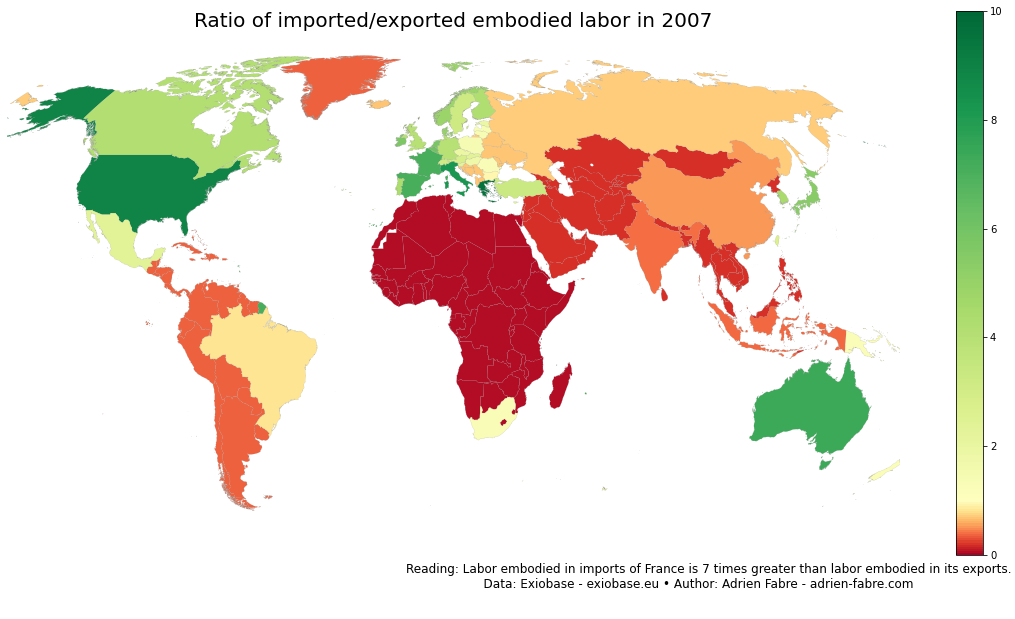

In [301]:
fig, ax = plt.subplots(1, figsize=(20, 10))
choropleth_map = merged.dropna().plot(ax=ax,column='imp/exp', cmap='RdYlGn', linewidth=0.1, edgecolor='grey',
                                      clim=(0, 10), norm=MidpointNormalize(midpoint=1,vmin=0, vmax=10)) # scheme: 'equal_interval', fisher_jenks or 'quantiles'
# merged[merged[var].isnull()].plot(ax=choropleth_map, edgecolor='white', color='lightgrey', linewidth=0.1)
ax.axis('off')
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=MidpointNormalize(midpoint=1,vmin=0, vmax=10))
sm._A = []
cbar = fig.colorbar(sm)
ax.set_xlim([-1.3e7, 1.5e7])
choropleth_map.set_title('Ratio of imported/exported embodied labor in 2007', fontdict={'fontsize': 20})
choropleth_map.annotate('Reading: Labor embodied in imports of France is 7 times greater than labor embodied in its exports.\n                    Data: Exiobase - exiobase.eu • Author: Adrien Fabre - adrien-fabre.com'\
                        , xy=(0.4, 0.05), size=12, xycoords='figure fraction')
# plt.savefig('imp-exp embodied labor.png')

(-18488885.869646862,
 18488885.852501005,
 -6644588.053183334,
 9056016.981444381)

(-13000000.0, 15000000.0)

Text(0.5,1,'Ratio of imported embodied labor over domestic labor in 2007')

Text(0.3,0.05,'Data: Exiobase - exiobase.eu • Author: Adrien Fabre - adrien-fabre.com')

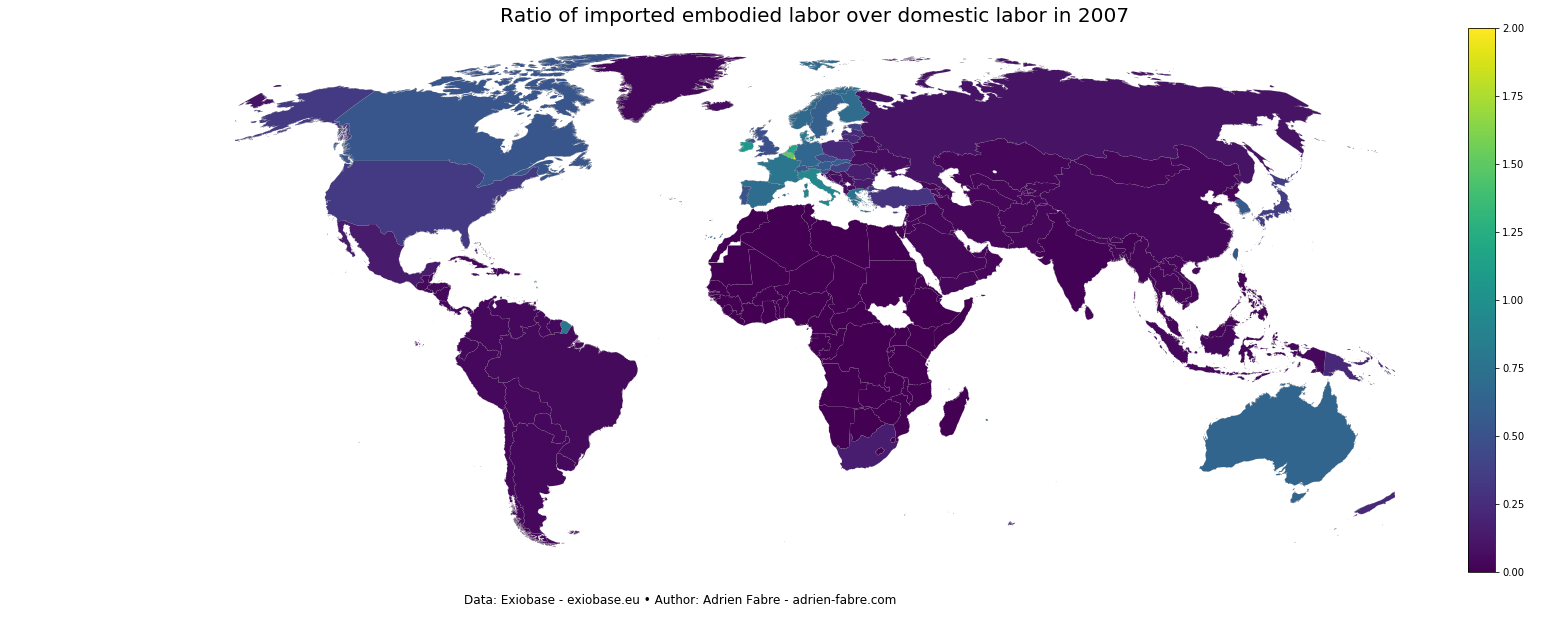

In [412]:
# scheme = 'equal_interval' or 'quantiles'
nb_colors = 10
fig, ax = plt.subplots(1, figsize=(26, 10))
merged.dropna().plot(ax=ax, column='share_import', cmap='viridis', k = nb_colors, linewidth=0.1, edgecolor='grey')
# merged[merged[var].isnull()].plot(ax=choropleth_map, edgecolor='white', color='lightgrey', linewidth=0.1)
ax.axis('off')
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=2))
sm._A = []
cbar = fig.colorbar(sm)
ax.set_xlim([-1.3e7, 1.5e7])
ax.set_title('Ratio of imported embodied labor over domestic labor in 2007', fontdict={'fontsize': 20})
ax.annotate('Data: Exiobase - exiobase.eu • Author: Adrien Fabre - adrien-fabre.com', xy=(0.3, 0.05), size=12, xycoords='figure fraction')
# plt.savefig('imported labor over domestic.png')

(-18488885.869646866, 18488885.85250101, -6644588.053183334, 9056016.981444381)

(-13000000.0, 15000000.0)

Text(0.5,1,'Ratio of imported/exported embodied labor over GDP per capita (in 2007)')

Text(0.4,0.05,'\n                    Data: Exiobase - exiobase.eu • Author: Adrien Fabre - adrien-fabre.com')

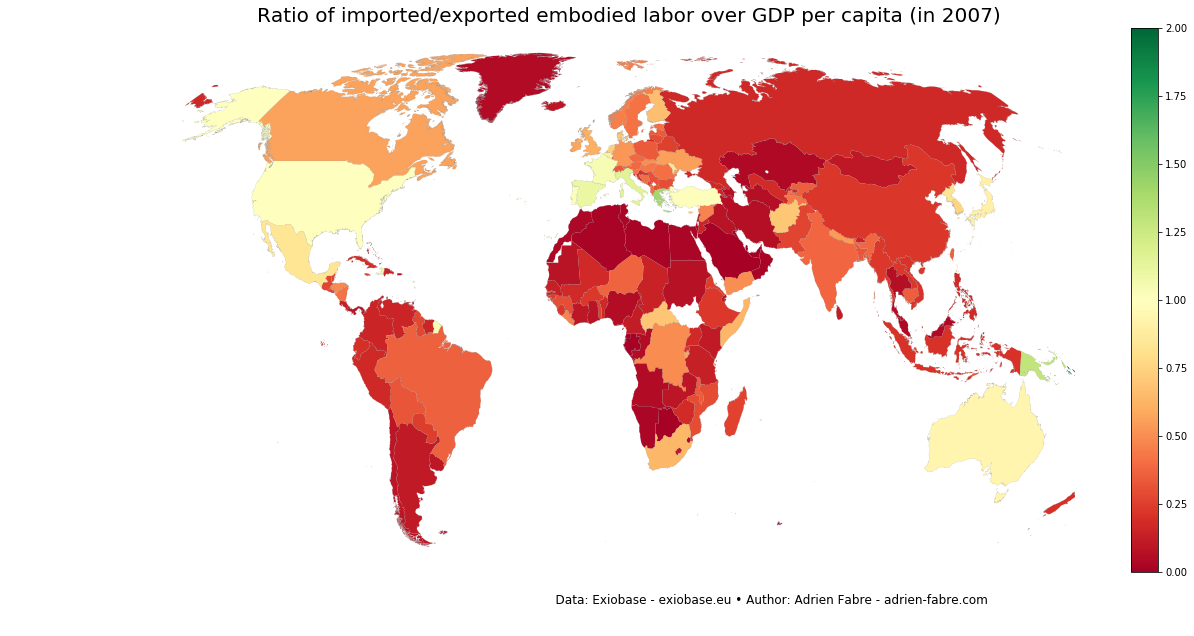

In [444]:
fig, ax = plt.subplots(1, figsize=(20, 10))
choropleth_map = merged.dropna().plot(ax=ax,column='elasticity_labor_GDPpc', cmap='RdYlGn', linewidth=0.1, edgecolor='grey',
                                      clim=(0, 10), norm=MidpointNormalize(midpoint=1,vmin=0, vmax=2)) # scheme: 'equal_interval', fisher_jenks or 'quantiles'
# merged[merged[var].isnull()].plot(ax=choropleth_map, edgecolor='white', color='lightgrey', linewidth=0.1)
ax.axis('off')
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=MidpointNormalize(midpoint=1,vmin=0, vmax=2))
sm._A = []
cbar = fig.colorbar(sm)
ax.set_xlim([-1.3e7, 1.5e7])
choropleth_map.set_title('Ratio of imported/exported embodied labor over normalized GDP per capita (in 2007)', fontdict={'fontsize': 20})
choropleth_map.annotate('\n                    Data: Exiobase - exiobase.eu • Author: Adrien Fabre - adrien-fabre.com'\
                        , xy=(0.4, 0.05), size=12, xycoords='figure fraction')
# plt.savefig('imp-exp embodied labor.png')

(-18488885.869646866, 18488885.85250101, -6644588.053183334, 9056016.981444381)

(-13000000.0, 15000000.0)

Text(0.5, 1.0, 'Hourly wage of exports (in $, 2007)')

Text(0.4, 0.05, '                                     Reading: Hourly wage of exports from France is $45.\n                    Data: Exiobase - exiobase.eu • Author: Adrien Fabre - adrien-fabre.com')

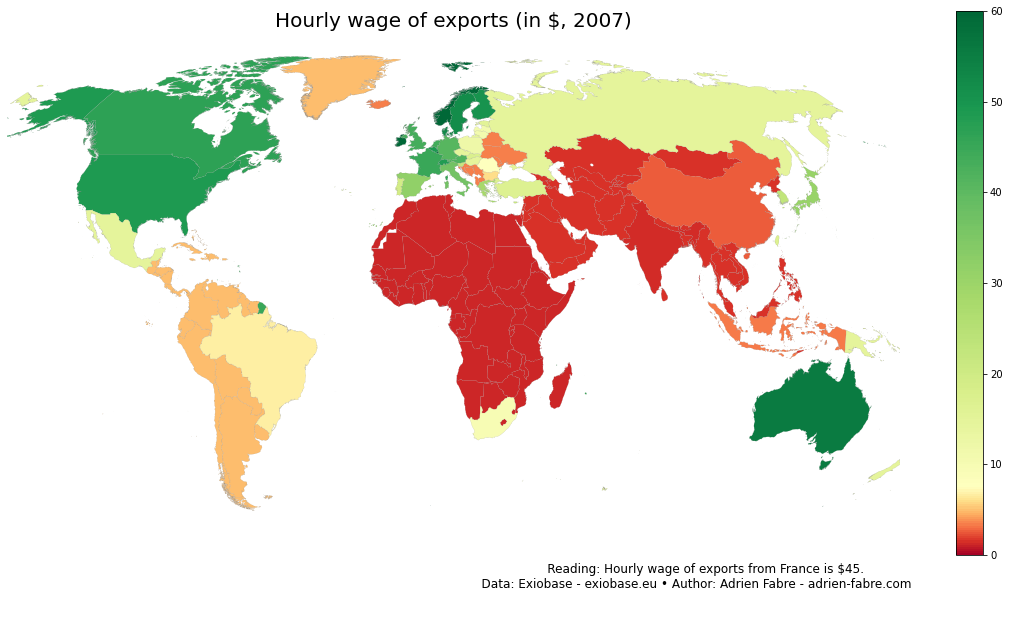

In [308]:
fig, ax = plt.subplots(1, figsize=(20, 10))
choropleth_map = merged.dropna().plot(ax=ax,column='hours_per_va_in_export', cmap='RdYlGn', linewidth=0.1, edgecolor='grey',
                                      clim=(0, 60), norm=MidpointNormalize(midpoint=average_hours_per_va,vmin=0, vmax=60)) # scheme: 'equal_interval', fisher_jenks or 'quantiles'
# merged[merged[var].isnull()].plot(ax=choropleth_map, edgecolor='white', color='lightgrey', linewidth=0.1)
ax.axis('off')
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=MidpointNormalize(midpoint=average_hours_per_va,vmin=0, vmax=60))
sm._A = []
cbar = fig.colorbar(sm)
ax.set_xlim([-1.3e7, 1.5e7])
choropleth_map.set_title('Hourly wage of exports (in $, 2007)', fontdict={'fontsize': 20})
choropleth_map.annotate('                                     Reading: Hourly wage of exports from France is $45.\n                    Data: Exiobase - exiobase.eu • Author: Adrien Fabre - adrien-fabre.com'\
                        , xy=(0.4, 0.05), size=12, xycoords='figure fraction')
# plt.savefig('hourly wage exports.png')

(-18488885.869646866, 18488885.85250101, -6644588.053183334, 9056016.981444381)

(-13000000.0, 15000000.0)

Text(0.5, 1.0, 'Difference between exported and imported labor relative to labor force (2007)')

Text(0.2, 0.05, 'Reading: A workforce as big as 64% of the French workforce works for French consumers, in net (i.e. after subtracting French working for foreigners).\n                                                                              Data: Exiobase - exiobase.eu • Author: Adrien Fabre - adrien-fabre.com')

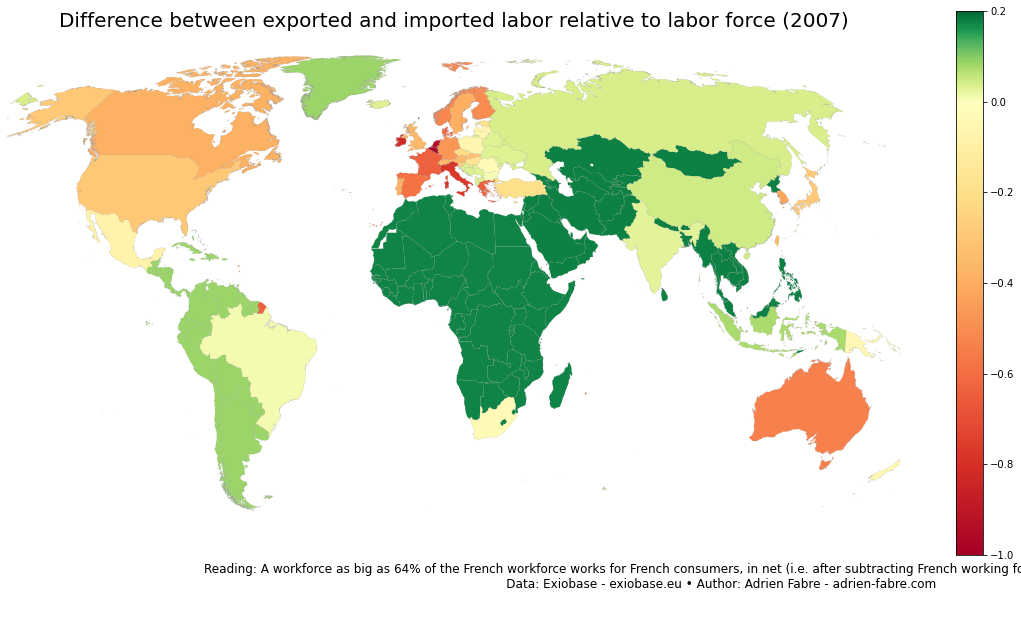

In [319]:
fig, ax = plt.subplots(1, figsize=(20, 10))
choropleth_map = merged.dropna().plot(ax=ax,column='share_net_export', cmap='RdYlGn', linewidth=0.1, edgecolor='grey',
                                      clim=(-1, 0.2), norm=MidpointNormalize(midpoint=0,vmin=-1, vmax=0.2)) # scheme: 'equal_interval', fisher_jenks or 'quantiles'
# merged[merged[var].isnull()].plot(ax=choropleth_map, edgecolor='white', color='lightgrey', linewidth=0.1)
ax.axis('off')
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=MidpointNormalize(midpoint=0,vmin=-1, vmax=0.2))
sm._A = []
cbar = fig.colorbar(sm)
ax.set_xlim([-1.3e7, 1.5e7])
choropleth_map.set_title('Difference between exported and imported labor relative to labor force (2007)', fontdict={'fontsize': 20})
choropleth_map.annotate('Reading: A workforce as big as 64% of the French workforce works for French consumers, in net (i.e. after subtracting French working for foreigners).\n                                                                              Data: Exiobase - exiobase.eu • Author: Adrien Fabre - adrien-fabre.com'\
                        , xy=(0.2, 0.05), size=12, xycoords='figure fraction')
plt.savefig('share labor net export.png')